# Гипотеза

Поиск более оптимальных параметров с помощью библиотеки `ray` позволит улучшить качество модели.  
Текущее максимальное значение метрики на тестовых данных `f1=0.77`  
Пока лучшее на кросс-валидации `mean test_score = 0.7161425084850291`

>**итог**  
> подобранные параметры качество не улучшили...  
> нужно попробовать подобрать меньший learning_rate и n_estimators

In [2]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score
from ray import tune

In [3]:
# Const
RANDOM_STATE = 0
min_rr = 460
max_rr = 963*1.2

print(min_rr, '/', max_rr)

460 / 1155.6


# Полезные методы

In [9]:
def make_XY(df, scaler):
    """
    Подготовка признаков для обучения модели
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    y = df.y.to_numpy()
    X = scaler.transform(df.drop(['y','id','time'], axis=1).to_numpy())

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()
        
        
def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def make_dataset(data):
    """
    Автоматизация подготовки датасета
    """
    df = data.copy()
    ids = df.id.unique()
    for rr_id in ids:
        mask = (df.id==rr_id)
        df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
        df.loc[mask, 'x_diff'] = df[mask].x.diff()
        df.fillna(method='bfill', inplace=True)
        df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
        for i in range(1,5):
            # добавим в признаки 4 следующие точки
            df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
            # и 4 предыдущие точки
            df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
        df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
        df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
        df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
        df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
        df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
        df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
        df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        
    return df

# Данные

In [5]:
with open('../pipelines/dataset-mms-pipeline-2.pkl', 'rb') as f:
    df = pickle.load(f)
with open('../pipelines/scaler-mms-pipeline-2.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
X,y = make_XY(df, scaler)
print(X.shape, y.shape)

train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes] 
y_train = y[train_indexes]
X_test = X[test_indexes]
y_test = y[test_indexes]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60487, 19) (60487,)
(48389, 19) (48389,)
(12098, 19) (12098,)


# Поиск лучших гиперпараметров

config = {
    "max_depth": tune.randint(2, 30),
    "n_estimators": tune.randint(3, 1000),
    "gamma": tune.uniform(0.0, 1.0),
    "learning_rate": tune.uniform(0.0, 1.0),
    'reg_lambda': tune.randint(1, 100),
    'reg_alpha': tune.randint(1, 100),
    'subsample': tune.uniform(0.1, 1.0),
    'random_state': 0,
    'n_jobs': -1,    
}

In [6]:
config = {
    "max_depth": tune.randint(-1, 100),
    'num_leaves': tune.randint(1, 100),
    "n_estimators": 3860,
    "learning_rate": 0.01,
    'random_state': 0,
    'n_jobs': -1,    
}

In [7]:
def find_optimal_hyperparameters(config):
    model = lgb.LGBMClassifier(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_binary = f1_score(y_test, y_pred)
    tune.report(
        current_metric = f1_binary, 
        done = True
    )

In [8]:
%%time

analysis = tune.run(
    find_optimal_hyperparameters,
    metric="current_metric",
    mode="max",
    config=config,
    num_samples=300,
    verbose=1
)

Trial name,# failures,error file
find_optimal_hyperparameters_91267_00010,1,"/home/msemezhov/ray_results/find_optimal_hyperparameters_2021-06-19_13-52-20/find_optimal_hyperparameters_91267_00010_10_max_depth=79,num_leaves=1_2021-06-19_13-53-30/error.txt"
find_optimal_hyperparameters_91267_00166,1,"/home/msemezhov/ray_results/find_optimal_hyperparameters_2021-06-19_13-52-20/find_optimal_hyperparameters_91267_00166_166_max_depth=24,num_leaves=1_2021-06-19_14-11-56/error.txt"


TuneError: ('Trials did not complete', [find_optimal_hyperparameters_91267_00010, find_optimal_hyperparameters_91267_00166])

# Обучение модели

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

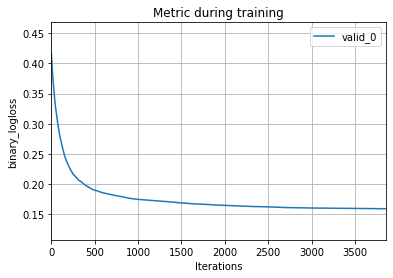

In [10]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, 
                           max_depth=98, num_leaves=26,
                           random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test,y_test), eval_metric='f1', verbose=False)

lgb.plot_metric(model)

# Cross validation

In [11]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, 
                           max_depth=98, num_leaves=26,
                           random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())
print('current best mean test_score = 0.7161425084850291')

test_score: [0.80970149 0.7098831  0.56166792 0.75641828 0.74196511]
mean test_score = 0.7159271816272292
current best mean test_score = 0.7161425084850291


> подобранные параметры качество не улучшили...